# Experiments Notebook 1


In [1]:
import os
import os.path
import pickle
import bz2
from glob import glob
import random
import time
import shutil
from datetime import datetime
import pathlib
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split
from kerashypetune import KerasGridSearch


In [2]:
import preprocessing as pp

In [3]:
from tqdm.auto import tqdm

In [4]:
pd.set_option("display.max_columns", None)

### Load the golden data

In [7]:
# Windows version
golden_dataset_file_name = os.path.join('..', '..', 'data', 'golden', 'feeFiFoFum.pbz2')

# data = bz2.BZ2File(golden_dataset_file_name,'rb')
with bz2.BZ2File(golden_dataset_file_name,'rb') as data:
    df = pd.read_pickle(data)


### Clean up the data

#### Drop non-numeric and unnecessary columns

In [8]:
cols = ['NYT_ConfirmedCases.data','NYT_ConfirmedDeaths.data','NYT_ConfirmedDeaths.missing','county','LND110210','countyStateName','stateFip','countyFip']

df.drop(cols, axis=1, inplace=True)

#### Temporarily, replace FIPS codes with latitude and longitude of the centroid of each county

counties = pd.read_csv('../noah/2021_Gaz_counties_national.txt', delimiter='\t')
counties.rename(columns={'INTPTLONG                                                                                                               ': 'longitude',
                        'INTPTLAT': 'latitude'}, inplace=True)
# counties.columns = counties.columns.str.replace(" ", "")

counties = counties[['GEOID', 'latitude', 'longitude' ]]
df.fips = df.fips.astype('int64')

df = df.merge(counties, how='left', left_on='fips', right_on='GEOID')
df.drop(['GEOID'], axis=1, inplace=True)

#### Replace dates with monotonically increasing integers starting with the minimum date

df.dates = pd.to_datetime(df.dates, format='%Y-%m-%d')
min_date = min(df.dates)
max_date = max(df.dates)
min_date, max_date, df.dates.dtype

df['day'] =(df.dates - min_date).dt.days
df.drop(['dates'], axis=1, inplace=True)

#### Replace the integer representation of date with sin and cosine encoding

cyclical_interval = 365
continuous_interval = 3650
df['cyclical_sin'] = np.sin((df.day * 2 * np.pi)/cyclical_interval)
df['cyclical_cos'] = np.cos((df.day * 2 * np.pi)/cyclical_interval)
df['continuous_sin'] = np.sin((df.day * 2 * np.pi)/continuous_interval)
df['continuous_cos'] = np.cos((df.day * 2 * np.pi)/continuous_interval)
df.drop('day', axis=1, inplace=True)

# crossed_latlong = pp.get_latlong_fc(df)

lat_buckets = list(np.linspace(df.latitude.min(), df.latitude.max(),100))
long_buckets = list(np.linspace(df.longitude.min(), df.longitude.max(),100))

#make feature columns
lat_fc = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('latitude'),lat_buckets)
long_fc= tf.feature_column.bucketized_column(tf.feature_column.numeric_column('longitude'),long_buckets)
    
# crossed columns tell the model how the features relate
crossed_latlong = tf.feature_column.crossed_column(keys=[lat_fc, long_fc], hash_bucket_size=1000) # No precise rule, maybe 1000 buckets will be good?
    
embedded_latlong = tf.feature_column.embedding_column(crossed_latlong,9)

feature_layer = tf.keras.layers.DenseFeatures(embedded_latlong)

df[['geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']] = feature_layer({'latitude': df.latitude, 'longitude': df.longitude})

# df.drop(['longitude', 'latitude'], axis=1, inplace=True)

#### Normalize the data

In [9]:
cols_to_normalize = [
       'TotalPopulation.data', 'MaleAndFemale_AtLeast65_Population.data',
       'Male_Total_Population.data', 'Female_Total_Population.data',
       'MaleAndFemale_Under18_Population.data', 'BLS_EmployedPopulation.data',
       'BLS_EmployedPopulation.missing', 'BLS_UnemployedPopulation.data',
       'BLS_UnemployedPopulation.missing', 'BLS_UnemploymentRate.data',
       'BLS_UnemploymentRate.missing', 'BLS_LaborForcePopulation.data',
       'BLS_LaborForcePopulation.missing', 'AverageDailyTemperature.data',
       'AverageDailyTemperature.missing', 'AverageDewPoint.data',
       'AverageDewPoint.missing', 'AverageRelativeHumidity.data',
       'AverageRelativeHumidity.missing', 'AverageSurfaceAirPressure.data',
       'AverageSurfaceAirPressure.missing', 'AveragePrecipitationTotal.data',
       'AveragePrecipitationTotal.missing', 'AveragePrecipitation.data',
       'AveragePrecipitation.missing', 'AverageWindDirection.data',
       'AverageWindDirection.missing', 'AverageWindSpeed.data',
       'AverageWindSpeed.missing', 'hospitalIcuBeds', 'hospitalStaffedBeds',
       'hospitalLicensedBeds', 'latestTotalPopulation', 'jhu_daily_death',
       'jhu_daily_cases', 'jhu_daily_new_cases', 
    'jhu_daily_death_rolling_7',
       'jhu_daily_cases_rolling_7', 'jhu_daily_new_cases_rolling_7',
       'jhu_daily_death_rolling_30', 'jhu_daily_cases_rolling_30',
       'jhu_daily_new_cases_rolling_30', 'jhu_death_rate', 'jhu_case_rate',
       'jhu_new_case_rate', 'density', 'icu_beds_per_person',
       'staffed_beds_per_person', 'licensed_beds_per_person', 'cold_days',
       'hot_days', 'moderate_days', 'gte_65_percent', 'lt_18_percent',
       'employed_percent', 'unemployed_percent', 'totalMoved',
       'movedWithinState', 'movedWithoutState', 'movedFromAbroad',
       'publicTrans', 'totalTrans', 'householdsTotal', 'houseWith65',
       'house2+with65', 'houseFamily65', 'houseNonfam65', 'houseNo65',
       'house2+No65', 'houseFamilyNo65', 'houseNonfamNo65',
       'householdStructuresTotal', 'householdIncomeMedian', 'gini',
       'hoursWorkedMean', 'unitsInStructure', 'healthInsTotal',
       'healthInsNativeWith', 'healthInsForeignNatWith',
       'healthInsForeignNoncitWith', 'healthInsForeignNatNo',
       'healthInsForeignNoncitNo', 'healthInsNativeNo', 'pm25','latitude','longitude']

In [10]:
cols_raw = ['fips','JHU_ConfirmedCases.data', 'JHU_ConfirmedDeaths.data', 'cyclical_sin', 'cyclical_cos', 'continuous_sin',
       'continuous_cos', 'geo0', 'geo1', 'geo2','geo3', 'geo4','geo5','geo6','geo7','geo8']

In [11]:
df_normalized = df[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = df[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)

#### Prepare the data for training

In [5]:
days_of_history = 30
days_to_predict = 7

In [6]:
# df.to_pickle('./prepped_data.pkl')
df = pd.read_pickle('./prepped_data.pkl')

In [8]:
fips = df.fips.unique()

# def x_generator(data, days_of_history=30, days_to_predict=7):
#     for j, fip in enumerate(fips):
#         if not j % 100: print(j, end=' ')
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i - days_of_history: i, 1:].to_numpy()
#             yield data_matrix
            
# def y_generator(data, days_of_history=30, days_to_predict=7):
#     for fip in fips:
#         county = data[data.fips == fip]
#         for i in range(days_of_history, len(county) - days_to_predict):
#             data_matrix = data.iloc[i: i + days_to_predict, 1:3].to_numpy()
#             yield data_matrix
    
def xy_generator(data, days=37):
    for j, fip in enumerate(fips):
        #print status message
        if not j % 100: print(j, end=' ')
        #filter on fip then ignore it?
        county = data[data.fips == fip]
        for i in range(days, len(county) + 1):
            #Capturing fips intentionally to test theory
            data_matrix = county.iloc[i - days: i, :].to_numpy()
            yield data_matrix

In [51]:
j=0


0 

## Important thing

In [45]:
fip_choice = list(df.fips.unique())
rng = np.random.default_rng(RANDOM_SEED)
fip = rng.choice(fip_choice)
print(f"selected fips = {fip}")


j=0
days=37
shhhhh = 0

county_l = len(df[df['fips']==fip])
print(f"county_l = {county_l}")

selected fips = 8014
county_l = 622


In [50]:
for i in range(days, county_l + 1):
    #Capturing fips intentionally to test theory
    print(f"{i - days},{ i}")
    

0,37
1,38
2,39
3,40
4,41
5,42
6,43
7,44
8,45
9,46
10,47
11,48
12,49
13,50
14,51
15,52
16,53
17,54
18,55
19,56
20,57
21,58
22,59
23,60
24,61
25,62
26,63
27,64
28,65
29,66
30,67
31,68
32,69
33,70
34,71
35,72
36,73
37,74
38,75
39,76
40,77
41,78
42,79
43,80
44,81
45,82
46,83
47,84
48,85
49,86
50,87
51,88
52,89
53,90
54,91
55,92
56,93
57,94
58,95
59,96
60,97
61,98
62,99
63,100
64,101
65,102
66,103
67,104
68,105
69,106
70,107
71,108
72,109
73,110
74,111
75,112
76,113
77,114
78,115
79,116
80,117
81,118
82,119
83,120
84,121
85,122
86,123
87,124
88,125
89,126
90,127
91,128
92,129
93,130
94,131
95,132
96,133
97,134
98,135
99,136
100,137
101,138
102,139
103,140
104,141
105,142
106,143
107,144
108,145
109,146
110,147
111,148
112,149
113,150
114,151
115,152
116,153
117,154
118,155
119,156
120,157
121,158
122,159
123,160
124,161
125,162
126,163
127,164
128,165
129,166
130,167
131,168
132,169
133,170
134,171
135,172
136,173
137,174
138,175
139,176
140,177
141,178
142,179
143,180
144,181
145,182
146,1

In [29]:
dimlist=[]

In [30]:
indexerthing = []
for i in range(days, county_l+1):
    indexerthing.append(i)


In [31]:
len(indexerthing)

586

In [46]:
# stop = indexerthing[-1]
# start = indexerthing[-1]-37
# print(f"stop = {stop} start = {start}")
i = indexerthing[300]

i_sub_days= i-37
print(f" i_sub_days = {i_sub_days} : i = {i}")


 i_sub_days = 300 : i = 337


In [47]:
# fips
cdf = df[df['fips']==fip]
last = cdf.iloc[i_sub_days: i,:]

In [48]:
print(f"{last.shape}")
len(last.fips.unique())

(37, 102)


1

In [49]:
last.fips.unique()

array([8014], dtype=int64)

In [71]:
dm = df.iloc[i-days: i, :]
dimlist.append(dm)
print(f"len(dm) = {len(dm)}")
print(f"len(dimlist) = {len(dimlist)}")
print(f"dm contains {len(dm.fips.unique())} fips codes")

len(dm) = 37
len(dimlist) = 1
dm contains 1 fips codes


In [72]:
# xar = np.asarray(dimlist)
dimlist[0].head()

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,geo3,geo4,geo5,geo6,geo7,geo8,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
1,45001,1.0,0.0,0.154309,0.988023,0.015492,0.999880,-0.164297,-0.326711,-0.301677,0.142334,-0.264933,0.049212,-0.185036,0.02254,0.485642,-0.238993,-0.238355,-0.239445,-0.235928,-0.242679,-0.245749,-0.091305,-0.189151,-0.091305,-0.649514,-0.091305,-0.242401,-0.091305,0.820176,-0.03951,0.812216,-0.100712,0.010382,-0.038884,0.335846,-0.100712,-0.123349,-0.100712,-0.128330,-0.100712,0.834514,-0.038884,0.950305,-0.038884,-0.224076,-0.264794,-0.276526,-0.238993,-0.080026,-0.09767,-0.09767,-0.163466,-0.156654,-0.156654,-0.200562,-0.197839,-0.197839,-0.171681,-0.466692,-0.466692,-0.20837,-0.024962,-0.394361,-0.477797,-0.724554,-0.052828,0.729545,0.534913,-0.583297,0.322089,-0.649514,-0.238207,-0.308877,-0.295472,-0.214053,-0.119168,-0.243326,-0.247646,-0.238178,-0.240385,-0.238184,-0.271806,-0.249709,-0.252798,-0.252735,-0.242618,-0.247646,-1.040687,0.919901,-0.755243,-0.247926,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
2,45001,1.0,0.0,0.171293,0.985220,0.017213,0.999852,-0.164297,-0.326711,-0.301677,0.142334,-0.264933,0.049212,-0.185036,0.02254,0.485642,-0.238993,-0.238355,-0.239445,-0.235928,-0.242679,-0.245749,-0.091305,-0.189151,-0.091305,-0.649514,-0.091305,-0.242401,-0.091305,0.641821,-0.03951,0.614263,-0.100712,-0.116278,-0.038884,0.331202,-0.100712,-0.123349,-0.100712,-0.128330,-0.100712,1.431915,-0.038884,0.303915,-0.038884,-0.224076,-0.264794,-0.276526,-0.238993,-0.080026,-0.09767,-0.09767,-0.163466,-0.156654,-0.156654,-0.200562,-0.197839,-0.197839,-0.171681,-0.466692,-0.466692,-0.20837,-0.024962,-0.394361,-0.477797,-0.724554,-0.052828,0.729545,0.534913,-0.583297,0.322089,-0.649514,-0.238207,-0.308877,-0.295472,-0.214053,-0.119168,-0.243326,-0.247646,-0.238178,-0.240385,-0.238184,-0.271806,-0.249709,-0.252798,-0.252735,-0.242618,-0.247646,-1.040687,0.919901,-0.755243,-0.247926,-0.235997,-0.262976,-0.137842,-0.148042,-0.143646,-0.141956,-0.196056,0.811931,-0.830256,0.80029
3,45001,1.0,0.0,0.188227,0.982126,0.018934,0.

In [61]:
ilist = []
for i in indexerthing:
    ilist.append(i-days)


In [62]:
indexerthing[0]

37

## no longer thing

##### Save the raw X and Y to files of 50,000 sequences

In [52]:
Xi = []
j = 0

N_SAMPLES = 200

for i, x in tqdm(enumerate(xy_generator(df))):
    Xi.append(x)
    if i and not i % (N_SAMPLES - 1):
        X = np.asarray(Xi)
        np.save(os.path.join('.','data', f'x_{j}.npy'), X)
        j += 1
        Xi = []
    

0it [00:00, ?it/s]

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 

In [69]:
bad_fips = []
Xi[-1]
tfip=[]
for t in Xi:
    thing = {a[0] for a in t}
    bad_fips.append(thing)


In [72]:
if Xi:
    X = np.asarray(Xi)
    np.save(os.path.join('.','data', f'x_{j}.npy'), X)

# for i, x in tqdm(enumerate(xy_generator(df))):
#     Xi.append(x)
#     if i and not i % (N_SAMPLES - 1):
#         X = np.asarray(Xi)
#         np.save(os.path.join('.','norm_latlong_data', f'x_{j}.npy'), X)
#         j += 1
#         Xi = []
    
# if Xi:
#     X = np.asarray(Xi)
#     np.save(os.path.join('.','norm_latlong_data', f'x_{j}.npy'), X)
 

# Need to confirm all files contain only 1 fips code

##### Split into train, test, eval directories

In [10]:
RANDOM_SEED = 42
def set_seed():
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
set_seed()

In [20]:
x_files = glob('./data/x_*.npy')

#changing directory so I can stop regenerating everytime

# x_files = glob('./norm_latlong_data/x_*.npy')
random.shuffle(x_files)
n_files = len(x_files)
print(n_files)
n_train = int(n_files * 0.70)
print(n_train)
n_eval = int(n_files * 0.15)
print(n_eval)
n_test = n_files - n_train - n_eval
print(n_test)
train_files = x_files[:n_train]
# print(len(train_files))
eval_files = x_files[n_train:n_train+n_test]
# print(len(eval_files))
test_files = x_files[n_train+n_test:]
assert n_files == len(train_files) + len(eval_files) + len(test_files)
for (subdir, lst) in [['train', train_files], ['eval', eval_files], ['test', test_files]]:
    for file in lst:
        shutil.move(file, os.path.join('.', 'data', subdir))
        # shutil.move(file, os.path.join('.', 'norm_latlong_data', subdir))
        

8888
6221
1333
1334


##### Create the Tensorflow Dataset

In [ ]:
t= glob('*.png')
len(t)

In [17]:
test = np.load("./data/x_8018.npy")

In [12]:
np.set_printoptions(suppress=True)

In [23]:
test[0][0][0]

13287.0

In [24]:
hopefully_fips = []
for ar in test:
    for r in ar:
        hopefully_fips.append(r[0])

In [25]:
set_fips = set(hopefully_fips)

In [26]:
len(set_fips)

2

In [27]:
set_fips

{13287.0, 46125.0}

In [37]:
data_files = glob('./data/x_*.npy')
files = data_files
cycle_length = 5
# for i in range(0, len(files), cycle_length):
#     print(i)
i=205
subset = files[i:i + cycle_length]
np_arrays = [np.load(s) for s in subset]
np_array = np.concatenate(np_arrays, axis=0)
    
  
  

In [30]:
tep=[]

for i in range(0, len(files), cycle_length):
    tep.append(i)


In [33]:
tep[541]

2705

In [38]:
np_array[0][0][0]
# for samp in np_array

45001.0

In [7]:
# "data" is the 7 day predictions
train_files = glob('./data/train/x_*.npy')
eval_files = glob('./data/eval/x_*.npy')
test_files = glob('./data/test/x_*.npy')

# train_files = glob('./norm_latlong_data/train/x_*.npy')
# eval_files = glob('./norm_latlong_data/eval/x_*.npy')
# test_files = glob('./norm_latlong_data/test/x_*.npy')

n_readers = 5
n_parse_threads = 5
len_array = 995


def create_generator(files, cycle_length=5):
    set_seed()
    random.shuffle(files)
    for i in range(0, len(files), cycle_length):
        subset = files[i:i + cycle_length]
        np_arrays = [np.load(s) for s in subset]
        np_array = np.concatenate(np_arrays, axis=0)
        np.random.shuffle(np_array)
        yield np_array

def split_xy(np_array):
    X = np_array[:, :-days_to_predict, :]
    y = np_array[:, -days_to_predict:, :1]
    return X, y

train_ds = tf.data.Dataset.from_generator(lambda: create_generator(train_files, cycle_length=n_readers),
                                          output_types=tf.float32)
train_ds = train_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

val_ds = tf.data.Dataset.from_generator(lambda: create_generator(eval_files, cycle_length=n_readers),
                                        output_types=tf.float32)
val_ds = val_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)

test_ds = tf.data.Dataset.from_generator(lambda: create_generator(test_files, cycle_length=n_readers),
                                         output_types=tf.float32)
test_ds = test_ds.map(split_xy, num_parallel_calls=n_parse_threads).prefetch(1)




## Building the model

In [13]:
# HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM', 'keras.layers.GRU']))
HP_LAYER_TYPE=hp.HParam('layer_type', hp.Discrete(['keras.layers.LSTM']))
HP_N_RECURRENT=hp.HParam('n_recurrent', hp.Discrete([3]))
# HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([32, 64, 128]))
HP_N_UNIT=hp.HParam('n_unit', hp.Discrete([256]))
HP_DROPOUT=hp.HParam('dropout', hp.Discrete([0.20]))
HP_LR=hp.HParam('lr', hp.Discrete([1e-3, 5e-3]))
METRIC_MAE = 'mae'
# HP_L2=



with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_LAYER_TYPE, HP_N_RECURRENT, HP_N_UNIT, HP_DROPOUT, HP_LR],
    metrics=[hp.Metric(METRIC_MAE, display_name='Mean Avg Error')],
  )

In [14]:
EPOCHS=30

def train_test_model(hparams, shape=(30,101), OUT_STEPS=7):
    set_seed()
    input = keras.layers.Input(shape=shape)
    last = input
    for i in range(hparams[HP_N_RECURRENT]):
        if i < hparams[HP_N_RECURRENT] - 1:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT], return_sequences=True)(last)
        else:
            last = eval(hparams[HP_LAYER_TYPE])(hparams[HP_N_UNIT])(last)
        
        if hparams[HP_DROPOUT]:
            last = keras.layers.Dropout(hparams[HP_DROPOUT])(last)
    if OUT_STEPS == 7:
        last = keras.layers.Dense(OUT_STEPS*1)(last)
        output = keras.layers.Reshape([OUT_STEPS, 1])(last)
    else:
        output = keras.layers.Dense(1)(last)
    
    model = keras.models.Model(inputs=input, outputs=output)
    
    model.compile(optimizer = Adam(learning_rate=hparams[HP_LR]),
                  loss='mae'
                 ) 
    print(model.summary())
    model.fit(train_ds,
            validation_data=val_ds,
            epochs=EPOCHS)
 
    val_loss = model.evaluate(test_ds)
    return val_loss
# def train_test_sequential(hparams, shape=(30,101)):
#     set_seed()
#     pass

def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        val_loss = train_test_model(hparams)
        tf.summary.scalar(METRIC_MAE, val_loss, step=1)

In [15]:
session_num = 0
for layer_type in HP_LAYER_TYPE.domain.values:
    for n_recurrent in HP_N_RECURRENT.domain.values:
        for n_unit in HP_N_UNIT.domain.values:
            for dropout in HP_DROPOUT.domain.values:
                for lr in HP_LR.domain.values:
                    hparams = {
                      HP_LAYER_TYPE: layer_type,
                      HP_N_RECURRENT: n_recurrent,
                      HP_N_UNIT: n_unit,
                      HP_DROPOUT: dropout,
                      HP_LR: lr
                    }
                    run_name = f'run-{session_num}-nrecu-{n_recurrent}'
                    print(f'--- Starting trial: {run_name}')
                    print({h.name: hparams[h] for h in hparams})
                    run(f'./logs/predict_7/debugging/{run_name}', hparams)
                    session_num += 1

--- Starting trial: run-0-nrecu-3
{'layer_type': 'keras.layers.LSTM', 'n_recurrent': 3, 'n_unit': 256, 'dropout': 0.2, 'lr': 0.001}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 101)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 30, 256)           366592    
                                                                 
 dropout_3 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_4 (LSTM)               (None, 30, 256)           525312    
                                                                 
 dropout_4 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               5253

In [ ]:
OUT_STEPS = 7 # days to predict
model = tf.keras.models.Sequential([
    tf.keras.layers.input(shape=(30,101)),
    tf.keras.layers.LSTM(hparams[HP_NUM_UNITS], return_sequences=False),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(OUT_STEPS*1),
    tf.keras.layers.Reshape([OUT_STEPS,1])
])

In [8]:
# Changing the model to predict 7 days ahead
OUT_STEPS = days_to_predict
number_of_features = 101
input = keras.layers.Input(shape=(30,101))
lstm1 = keras.layers.LSTM(256, return_sequences=True)(input)
dropout1 = keras.layers.Dropout(0.20)(lstm1)
lstm2 = keras.layers.LSTM(256, return_sequences=True)(dropout1)
dropout2 = keras.layers.Dropout(0.20)(lstm2)
lstm3 = keras.layers.LSTM(256, return_sequences=False)(dropout2)
dropout3 = keras.layers.Dropout(0.20)(lstm3)

dense = keras.layers.Dense(OUT_STEPS*1)(dropout3)
output = keras.layers.Reshape([OUT_STEPS, 1])(dense)

model = keras.models.Model(inputs=input, outputs=output)






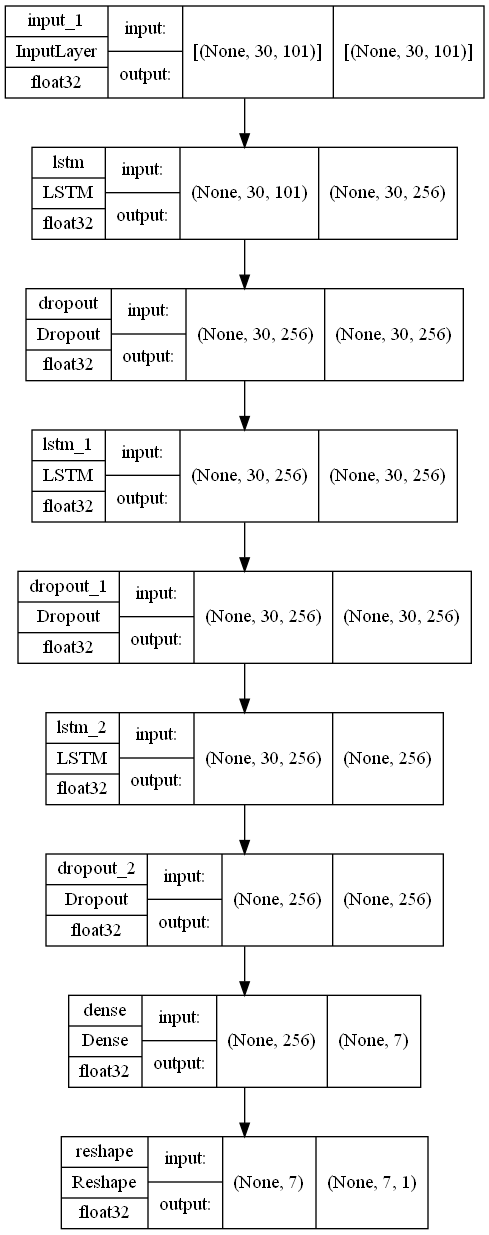

In [10]:
keras.utils.plot_model(model,  show_shapes=True, show_dtype=True, 
                       show_layer_activations=False, rankdir='TB')

In [9]:
NAME = '7_day_3_layer_reshape_100eps'
model.compile(optimizer = Adam(learning_rate=1e-3),  loss='mae',  metrics=['mse', 'mae',tf.keras.metrics.RootMeanSquaredError()])
checkpoint_cb = keras.callbacks.ModelCheckpoint(f'./data/model/{NAME}.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='mae', min_delta= 1e-8, patience=10, restore_best_weights=True)

tensorboard = keras.callbacks.TensorBoard(log_dir="logs/predict_7/{}".format(NAME))
history = model.fit(train_ds, epochs=100, 
                    validation_data=val_ds, 
                    callbacks=[tensorboard, checkpoint_cb, early_stopping_cb]
                   )


Epoch 1/100
1245/1245 [==============================] - 160s 125ms/step - loss: 1612.1249 - mse: 4218991.5000 - mae: 1612.1223 - root_mean_squared_error: 2054.0183 - val_loss: 1546.5856 - val_mse: 3879734.2500 - val_mae: 1546.5861 - val_root_mean_squared_error: 1969.7041
Epoch 2/100
1245/1245 [==============================] - 141s 112ms/step - loss: 1437.9738 - mse: 3426806.2500 - mae: 1437.9729 - root_mean_squared_error: 1851.1635 - val_loss: 1401.9852 - val_mse: 3187629.0000 - val_mae: 1401.9845 - val_root_mean_squared_error: 1785.3932
Epoch 3/100
1245/1245 [==============================] - 140s 112ms/step - loss: 1185.9231 - mse: 2717989.5000 - mae: 1185.9235 - root_mean_squared_error: 1648.6326 - val_loss: 1105.5730 - val_mse: 2431420.5000 - val_mae: 1105.5731 - val_root_mean_squared_error: 1559.3013
Epoch 4/100
1245/1245 [==============================] - 140s 112ms/step - loss: 996.2926 - mse: 2087032.0000 - mae: 996.2927 - root_mean_squared_error: 1444.6564 - val_loss: 931.40

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 101)]         0         
                                                                 
 lstm (LSTM)                 (None, 30, 256)           366592    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0     

In [11]:
model.save(f'./data/model/7_day_predict/good-{NAME}')

INFO:tensorflow:Assets written to: ./data/model/7_day_predict/good-7_day_3_layer_reshape_100eps\assets


INFO:tensorflow:Assets written to: ./data/model/7_day_predict/good-7_day_3_layer_reshape_100eps\assets


In [56]:
lmodel = keras.models.load_model(f'./data/model/7_day_predict/{NAME}')

In [13]:
model.evaluate(test_ds)


267/267 [==============================] - 31s 115ms/step - loss: 24.5820 - mse: 21697.6250 - mae: 24.5820 - root_mean_squared_error: 147.3011


[24.58204460144043, 21697.625, 24.58204460144043, 147.30113220214844]

## saving off a few counties for manual testing at random

In [19]:
fip_choice = list(df.fips.unique())
rng = np.random.default_rng(RANDOM_SEED)
selected_fips = rng.choice(fip_choice, 13)

In [23]:
a_few_counties = df[df['fips'].isin(selected_fips)].copy()

In [28]:
# a_few_counties

for fip in selected_fips:
    a_few_counties[a_few_counties['fips'] == fip].to_csv(f'./data/some_counties/fip_{fip}.csv', index=False)

In [14]:
a_county = pd.read_csv('./data/some_counties/fip_40013.csv')

In [15]:
df_normalized = a_county[cols_to_normalize]
df_normalized = (df_normalized - df_normalized.mean())/df_normalized.std()
df_raw = a_county[cols_raw]
df = pd.concat([df_raw, df_normalized], axis=1)

In [16]:
df.head()

,fips,JHU_ConfirmedCases.data,JHU_ConfirmedDeaths.data,cyclical_sin,cyclical_cos,continuous_sin,continuous_cos,geo0,geo1,geo2,geo3,geo4,geo5,geo6,geo7,geo8,TotalPopulation.data,MaleAndFemale_AtLeast65_Population.data,Male_Total_Population.data,Female_Total_Population.data,MaleAndFemale_Under18_Population.data,BLS_EmployedPopulation.data,BLS_EmployedPopulation.missing,BLS_UnemployedPopulation.data,BLS_UnemployedPopulation.missing,BLS_UnemploymentRate.data,BLS_UnemploymentRate.missing,BLS_LaborForcePopulation.data,BLS_LaborForcePopulation.missing,AverageDailyTemperature.data,AverageDailyTemperature.missing,AverageDewPoint.data,AverageDewPoint.missing,AverageRelativeHumidity.data,AverageRelativeHumidity.missing,AverageSurfaceAirPressure.data,AverageSurfaceAirPressure.missing,AveragePrecipitationTotal.data,AveragePrecipitationTotal.missing,AveragePrecipitation.data,AveragePrecipitation.missing,AverageWindDirection.data,AverageWindDirection.missing,AverageWindSpeed.data,AverageWindSpeed.missing,hospitalIcuBeds,hospitalStaffedBeds,hospitalLicensedBeds,latestTotalPopulation,jhu_daily_death,jhu_daily_cases,jhu_daily_new_cases,jhu_daily_death_rolling_7,jhu_daily_cases_rolling_7,jhu_daily_new_cases_rolling_7,jhu_daily_death_rolling_30,jhu_daily_cases_rolling_30,jhu_daily_new_cases_rolling_30,jhu_death_rate,jhu_case_rate,jhu_new_case_rate,density,icu_beds_per_person,staffed_beds_per_person,licensed_beds_per_person,cold_days,hot_days,moderate_days,gte_65_percent,lt_18_percent,employed_percent,unemployed_percent,totalMoved,movedWithinState,movedWithoutState,movedFromAbroad,publicTrans,totalTrans,householdsTotal,houseWith65,house2+with65,houseFamily65,houseNonfam65,houseNo65,house2+No65,houseFamilyNo65,houseNonfamNo65,householdStructuresTotal,householdIncomeMedian,gini,hoursWorkedMean,unitsInStructure,healthInsTotal,healthInsNativeWith,healthInsForeignNatWith,healthInsForeignNoncitWith,healthInsForeignNatNo,healthInsForeignNoncitNo,healthInsNativeNo,pm25,latitude,longitude
0,40013,1.0,0.0,0.238673,0.971100,0.024098,0.999710,-0.332043,-0.312,-0.431626,0.014806,0.281618,0.091997,-0.657335,-0.068658,0.33078,NaN,NaN,-0.999189,0.999189,NaN,-0.901608,0.999189,-0.848593,0.999189,-0.723287,0.999189,-2.24258,0.999189,0.227937,0.999189,0.028638,0.999189,-0.409685,NaN,0.090212,0.999189,0.999189,0.999189,NaN,0.999189,-0.577871,NaN,0.123611,NaN,-0.999189,NaN,NaN,NaN,-0.164766,-0.247784,-0.247784,-0.439314,-0.651121,-0.651121,-0.844535,-0.906838,-0.906838,-0.439314,-0.651121,-0.651121,0.999189,0.999189,NaN,NaN,-0.470556,-0.999189,0.470556,0.999189,NaN,0.723287,-0.723287,NaN,-0.999189,-0.999189,-0.999189,-0.999189,NaN,-0.999189,NaN,NaN,NaN,0.999189,0.999189,0.999189,-0.999189,-0.999189,-0.999189,0.999189,NaN,0.999189,NaN,-0.999189,NaN,NaN,NaN,0.999189,-0.999189,-0.999189,NaN,NaN,-0.999189
1,40013,1.0,0.0,0.255353,0.966848,0.025818,0.999667,-0.332043,-0.312,-0.431626,0.014806,0.281618,0.091997,-0.657335,-0.068658,0.33078,NaN,NaN,-0.999189,0.999189,NaN,-0.901608,0.999189,-0.848593,0.999189,-0.723287,0.999189,-2.24258,0.999189,0.757852,0.999189,0.738327,0.999189,-0.233119,NaN,0.057936,0.999189,0.999189,0.999189,NaN,0.999189,0.826072,NaN,1.548549,NaN,-0.999189,NaN,NaN,NaN,-0.164766,-0.247784,-0.247784,-0.439314,-0.651121,-0.651121,-0.844535,-0.906838,-0.906838,-0.439314,-0.651121,-0.651121,0.999189,0.999189,NaN,NaN,-0.470556,-0.999189,0.470556,0.999189,NaN,0.723287,-0.723287,NaN,-0.999189,-0.999189,-0.999189,-0.999189,NaN,-0.999189,NaN,NaN,NaN,0.999189,0.999189,0.999189,-0.999189,-0.999189,-0.999189,0.999189,NaN,0.999189,NaN,-0.999189,NaN,NaN,NaN,0.999189,-0.999189,-0.999189,NaN,NaN,-0.999189
2,40013,1.0,0.0,0.271958,0.962309,0.027539,0.999621,-0.332043,-0.312,-0.431626,0.014806,0.281618,0.091997,-0.657335,-0.068658,0.33078,NaN,NaN,-0.999189,0.999189,NaN,-0.901608,0.999189,-0.848593,0.999189,-0.723287,0.999189,-2.24258,0.999189,0.528446,0.999189,0.778029,0.999189,0.380921,NaN,0.047126,0.999189,0.999189,0.999189,NaN,0.999189,0.695588,NaN,0.944563,NaN,-0.999189

In [27]:
to_network = df.iloc[100:130].copy()
prediction_truth = df.iloc[131:138]

(30, 102)

In [28]:
a_county.iloc[131:137].shape

(6, 102)

In [122]:
sus_county = np.load("./data/train/x_4770.npy")


In [124]:
sus_county[0][0]

array([ 7.13000000e+02,  1.50000000e+01, -6.28762815e-01, -7.77597147e-01,
        3.72921232e-01,  9.27863004e-01,  2.78552920e-01,  6.57205284e-01,
        2.11992234e-01, -4.93210047e-01,  1.99943587e-01, -2.34507412e-01,
        2.78676987e-01, -3.18260789e-02,  6.80260509e-02, -2.38993418e-01,
       -2.38354639e-01, -2.39444537e-01, -2.35927738e-01, -2.42678694e-01,
       -2.46207128e-01, -9.13054559e-02, -1.81514680e-01, -9.13054559e-02,
       -2.63403006e-01, -9.13054559e-02, -2.42031039e-01, -9.13054559e-02,
        6.43280784e-03, -3.95103232e-02,  3.86510092e-01, -1.00711668e-01,
        1.01869162e+00, -3.88840362e-02,  3.48101161e-01, -1.00711668e-01,
       -1.23349300e-01, -1.00711668e-01, -1.28329529e-01, -1.00711668e-01,
       -1.56898320e+00, -3.88840362e-02, -1.21758718e+00, -3.88840362e-02,
       -2.24076373e-01, -2.64794144e-01, -2.76526319e-01, -2.38993418e-01,
       -8.00257794e-02, -9.15961078e-02, -9.15961078e-02, -1.63466122e-01,
       -1.42291575e-01, -

<AxesSubplot:>

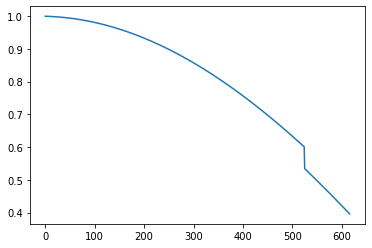

In [20]:
a_county['continuous_cos'].plot()

<AxesSubplot:>

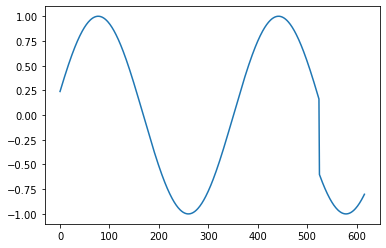

In [21]:
a_county['cyclical_sin'].plot()

In [57]:
y=test[:, -days_to_predict:, :1]

In [58]:
y.shape

(199, 7, 1)

In [59]:
y[0][0]

array([2586.])

In [60]:
hopefully_y = []
for ar in y:
    hopefully_y.append(ar[0][0])

In [62]:
len(set(hopefully_y))

102